!pwd

## import libraries

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pandas as pd
import pickle
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [98]:
# There are totla 129971 records.
wine_data = pd.read_csv("../../data/raw/winemag-data-130k-v2.csv") 

# Data cleaning

In [99]:
wine_data['country'] = wine_data['country'].fillna("Unknown")
wine_data['designation'] = wine_data['designation'].fillna("Unknown")
wine_data['province'] = wine_data['province'].fillna("Unknown")
wine_data['region_1'] = wine_data['region_1'].fillna("Unknown")
wine_data['region_2'] = wine_data['region_2'].fillna("Unknown")
# wine_data['taster_name'] = wine_data['taster_name'].fillna("Unknown")
wine_data['taster_twitter_handle'] = wine_data['taster_twitter_handle'].fillna("Unknown")
wine_data['variety'] = wine_data['variety'].fillna("Unknown")
# wine_data['price'] = wine_data['price'].fillna(0)

#Drop the duplicate descriptions
wine_data = wine_data.drop_duplicates('description') # 10016 duplicates
wine_data.dropna(subset=['price','taster_name'], inplace = True) # 22597 records are unknown taster
wine_data = wine_data[wine_data['price']<=100]  # 3229 records are price>100 

Drop single taster's data less than 4000.

In [100]:
taster_count = wine_data['taster_name'].value_counts()
taster_drop = []
num = 0
for i in range(len(taster_count)):
    if taster_count.values[i] < 4000:
        num +=taster_count.values[i]
        taster_drop.append(taster_count.index[i])
wine_data = wine_data[(~wine_data['taster_name'].isin(taster_drop))]

In [101]:
wine_data.shape #(71088, 14)

(71088, 14)

## Save as pickle

In [107]:
# wine_data.to_pickle('../../data/processed/wine_data.pkl')

In [2]:
# with open('../../data/processed/wine_data.pkl', 'rb') as f:
#     wine_data = pickle.load(f)
# f.close()

There are only 637 bottles of wine have more than one taster's review.

In [102]:
wine_data[wine_data['title'].duplicated()].shape

(637, 14)

# Visualization

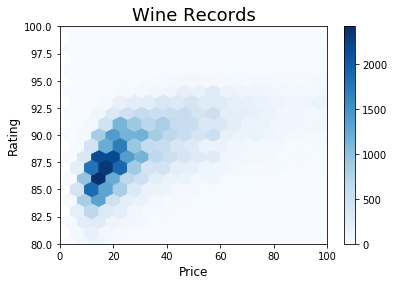

In [103]:
wine_data.plot.hexbin(x='price', y='points',gridsize=18,cmap=plt.cm.Blues, fontsize=10)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xlim(0,100)
plt.ylim(80,100)
plt.title('Wine Records', fontsize=18)
plt.savefig('../../references/figures/price_points.png', dpi=300)

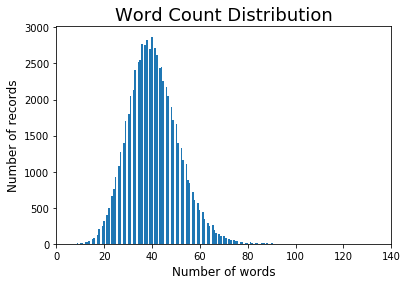

In [104]:
#set x for the histogram and set bins based on max
word_count = wine_data['description'].apply(lambda x: len(str(x).split(" ")))
n_bins = 180
#plot histogram
plt.hist(word_count , bins=n_bins)
plt.xlim(0,140)
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Number of records', fontsize=12)
plt.title('Word Count Distribution', fontsize=18)
plt.savefig('../../references/figures/word_count.png')

# Create new dataframe

## Copy columns I will use

In [105]:
wine = wine_data[['title','variety','country','taster_name','points','price','winery','description']]
wine.reset_index(drop=True, inplace=True)

Give unique id for title and taster

In [106]:
wine = wine.assign(id=(wine['taster_name']).astype('category').cat.codes)
wine = wine.rename(columns={'id': 'taster_id'})
wine = wine.assign(id=(wine['title']).astype('category').cat.codes)
wine = wine.rename(columns={'id': 'wine_id'})

## add category column according wine variety

In [30]:
red_list = ['Pinot Noir', 'Red Blend', 'Cabernet Sauvignon', 'Bordeaux-style Red Blend', 
            'Syrah','Malbec','Portuguese Red','Merlot', 'Tempranillo', 'Sangiovese','Zinfandel',
            'Nebbiolo', 'Rhône-style Red Blend', 'Cabernet Franc', 'Gamay', 'Shiraz']
white_list = ['Chardonnay', 'Riesling', 'Sauvignon Blanc','White Blend','Pinot Gris','Grüner Veltliner',
              'Portuguese White','Gewürztraminer', 'Viognier', 'Bordeaux-style White Blend', 'Tempranillo Blend']
sparkling_list = ['Sparkling Blend', 'Champagne Blend']
rose_list = ['Rosé']
other_list = []

for variety in red_list:
    red_rows = wine[wine['variety']==variety].index
    wine.loc[red_rows, 'category']='red'
for variety in white_list:
    white_rows = wine[wine['variety']==variety].index
    wine.loc[white_rows, 'category']='white'
for variety in sparkling_list:
    sparkling_rows = wine[wine['variety']==variety].index
    wine.loc[sparkling_rows, 'category']='sparkling'
for variety in rose_list:
    rose_rows = wine[wine['variety']==variety].index
    wine.loc[rose_rows, 'category']='rose'
for variety in other_list:
    other_rows = wine[wine['variety']==variety].index
    wine.loc[other_rows, 'category']='other'

# Analyze description

In [57]:
#It takes a few minutes.

#loops through descriptions and cleans them
clean_desc = []
for index, row in wine.iterrows():
    desc = row['description'].lower()
    #remove punctuation
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    #remove tags
    desc = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
    #remove digits and special chars
    desc = re.sub("(\\d|\\W)+"," ",desc)
    clean_desc.append(desc)
    
stop_words = set(stopwords.words("english"))
add_stopwords = ["wine", "drink"]
stop_words = stop_words.union(add_stopwords)

def remove_stopwords(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

clean_desc_wo_stopwords = list(map(remove_stopwords, clean_desc))
wine['desc_clean'] = clean_desc_wo_stopwords

## Flavor keywords on Wine Aroma Wheel

In [58]:
# "herbaceous" -> "herb","woody"->"wood"
pri_words = ["fruity", "spicy", "floral", "microbiological", "oxidized", "pungent",
                "chemical","earthy","wood","caramel","nutty","herb","vegetative"]
# "spicy","floral","oxidized","pungent","earthy", "caramel", "nutty"
sec_words = ["citrus","berry","tree","fruit","tropical","dried",
             "yeasty","lactic","cool","hot","sulfur",
             "petroleum","moldy","burned","phenolic","resinous",
             "fresh","canned","cooked"]
ter_words = [#fruity
    "grapefruit", "lemon", "blackberry", "raspberry", "strawberry", "currant",
    "cassis","cherry", "apricot", "peach", "apple", "pineapple", "melon", "banana",
    "jam", "raisin", "prune", "fig", "candied", "concord", "artificial", 
    "methyl", "anthranilate", 
    # spicy
    "licorice", "anise", "pepper", "cloves", 
    # floral
    "geranium", "violet", "rose","orange", "blossom",
    # mocribiological     
    "leesy", "baker", "yoghurt", "sweaty", "sauerkraut", "mousy", "horsey", "champagne"
    # oxidized 
    "oxidized", 
    # pungent
    "menthol", "alcohol", "rubbing",
    # chemical: "sulfur",
    "dioxide", "ethanol", "acetic", "grain","vinegar", "acid", 
    "polish", "ethyl", "wool", "dog", "match", "cabbage", "skunk", 
    "garlic", "gas", "mercaptan", "egg","hydrogen", "rubbery", "diesel", "kerosene",
    "plastic", "tar", "acetate",
    # earthy: "moldy"
    "cork", "mildew", "mushroom", "dusty", 
    # woody: "phenolic"
    "smoky", "burnt", "toast", "coffee", "medicinal", "bandaid", "sawdust", 
    "bacon", "oak", "cedar", "vanilla", 
    # caramel
    "honey", "butterscotch", "diacetyl", "soy", "sauce", "chocolate", "molasses", 
    # nutty
    "walnut", "hazelnut", "almond",
    # herbaceous/vegetative: "pepper"
    "grass", "eucalyptus", 
    "mint", "beans", "asparagus", "olive", "artichoke", "hay", "straw",
    "tea", "tobacco",
    #my add
    "tart", "cranberry", "savory", "mossy", "blueberry"]
flavor_words =  pri_words + sec_words + ter_words

## Stemming

In [59]:
#It takes a few minutes.

stm = SnowballStemmer("english") 
flavor_words_stem = [stm.stem(word) for word in flavor_words] 

def flavor_words_func(words):
    tokens = nltk.word_tokenize(words)
    stm = SnowballStemmer("english")
    flavor_words_list = [stm.stem(token) for token in tokens if stm.stem(token) in flavor_words_stem  ]
    return flavor_words_list

flavor_words_temp = list(map(flavor_words_func, clean_desc))
wine.loc[:,'flavor_words'] = [['other'] if x == [] else x for x in flavor_words_temp]
wine.loc[:,'flavor_words_str'] = wine.loc[:,'flavor_words'].apply(' '.join)

## Flavor Words Visualization

In [60]:
flavor_dict = dict()
for flavor in flavor_words_stem:
    num = wine[wine['flavor_words_str'].str.contains(flavor)].shape[0]
    flavor_dict[flavor] = num
flavor_dict_sorted = {k: v for k, v in sorted(flavor_dict.items(), key=lambda item: item[1], reverse=True)}

### plot the word cloud

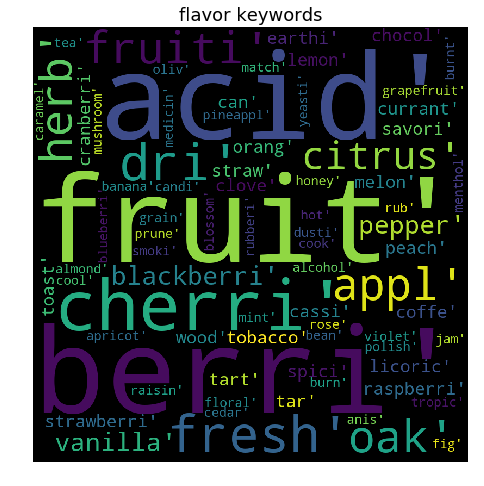

In [76]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', max_words = 1000, min_font_size = 20).generate(str(flavor_dict_sorted))

fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.title("flavor keywords", fontsize=18)
plt.axis('off')
fig.savefig("../../references/figures/flavor_keywords.png",frameon=False)
plt.show()

## Save as pickles

In [32]:
wine.shape # (71088, 13)

(71088, 14)

In [33]:
# wine.to_pickle('../../data/processed/wine.pkl')

In [34]:
# with open('../../data/processed/wine.pkl', 'rb') as f:
#     wine = pickle.load(f)
# f.close()

In [35]:
wine_sample = wine.sample(n=20000, random_state=123)
wine_sample.reset_index(drop=True, inplace=True)

# Content Based Filtering 

## TF-IDF Vectorizer

In [36]:
vectorizer = TfidfVectorizer()
tfidf_mx = vectorizer.fit_transform(wine_sample['flavor_words_str'])

In [37]:
#It takes a few minutes.
tfidf_cos = cosine_similarity(tfidf_mx, tfidf_mx)

In [38]:
with open('../../data/processed/tfidf_cos.pkl', 'wb') as f:
    pickle.dump(tfidf_cos, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

In [39]:
with open('../../data/processed/tfidf_cos.pkl', 'rb') as f:
    tfidf_cos = pickle.load(f)
f.close()

In [40]:
def recommend_wine(wine, wineid, n = 5, cosine_sim = tfidf_cos): 
    indices = list(wine.wine_id)
    if wineid not in indices:
        return []
    else:
        idx = wine[wine['wine_id'] == wineid].index[0]
    scores = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    # top n most similar wine indexes
    # use 1:n because 0 is the same wine entered
    top_n_idx = list(scores.iloc[1:n+1].index)
        
    return list(wine.iloc[top_n_idx]['wine_id'])

def get_wine_data(wine_id_list, wine_user):
    top_n_df = wine_user[wine_user['wine_id'].isin(wine_id_list)]
    top_n_df = top_n_df.sort_values("wine_id") 
    top_n_df.drop_duplicates(subset ="wine_id", keep = 'first', inplace = True) 
    top_n_df.index = np.arange(1, len(top_n_df) + 1)
    
    return top_n_df[['wine_id','title','country','variety','price','category','flavor_words_str', 'description']]

In [49]:
wine_id = 32789
tfidf_recommend_list = recommend_wine(wine_sample, wine_id , n=5, cosine_sim = tfidf_cos)
get_wine_data(tfidf_recommend_list, wine_sample)

,wine_id,title,country,variety,price,category,flavor_words_str,description
1,17082,Château de Jau 2002 Jaja Red (Vin de Pays d'Oc),France,Red Blend,9.0,red,tart cranberri cherri acid,"This blend of Syrah and Grenache has minty, we..."
2,20472,Cowhorn 2011 Sentience Syrah (Applegate Valley),US,Syrah,55.0,red,tart cranberri cherri fruit acid,"Tart and tannic, this has a sleek, almost stee..."
3,45120,Michael Florentino 2009 Cabernet Franc (Columb...,US,Cabernet Franc,26.0,red,acid cranberri fruit tart oak,"Restrained, with sharp acidity and cranberry-f..."
4,55913,Ryan Cochrane 2014 Fiddlestix Vineyard Pinot N...,US,Pinot Noir,43.0,red,cranberri tart cherri oliv,This is a very light expression of the grape f...
5,60186,Stemilt Creek 2010 Boss Lady Estate Grown Red ...,US,Red Blend,24.0,red,cherri dri cranberri tart,Equal parts Syrah and Merlot with a dash of Mo...
